In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pathlib import Path

## Data Exploration

In [2]:
mainFolder = '../Application/'
df = pd.read_csv(mainFolder + '/Data.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date_ym'] = df['Date'].dt.to_period('M')
df.head()

,Entity,Continent,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Date,Daily tests,Cases,Deaths,Date_ym
0,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-25,8.0,NaN,NaN,2020-02
1,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-26,5.0,NaN,NaN,2020-02
2,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-27,4.0,NaN,NaN,2020-02
3,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-28,1.0,NaN,NaN,2020-02
4,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-29,8.0,NaN,NaN,2020-02


In [5]:
df.drop_duplicates(['Entity'])['Median age'].describe()

count    104.000000
mean      32.567308
std        8.556794
min       16.000000
25%       27.000000
50%       32.000000
75%       41.000000
max       48.000000
Name: Median age, dtype: float64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38472 entries, 0 to 38471
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Entity                           38472 non-null  object        
 1   Continent                        38472 non-null  object        
 2   Latitude                         38472 non-null  float64       
 3   Longitude                        38472 non-null  float64       
 4   Average temperature per year     38472 non-null  int64         
 5   Hospital beds per 1000 people    38472 non-null  float64       
 6   Medical doctors per 1000 people  38472 non-null  float64       
 7   GDP/Capita                       38472 non-null  float64       
 8   Population                       38472 non-null  int64         
 9   Median age                       38472 non-null  int64         
 10  Population aged 65 and over (%)  38472 non-null  int64    

In [7]:
df.Entity.nunique() # 104 countries

104

In [8]:
df.Continent.unique()

array(['Europe', 'Africa', 'South America', 'Oceania', 'Asia',
       'North America'], dtype=object)

In [9]:
df.Date.min(), df.Date.max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2021-02-28 00:00:00'))

## Visualisation 1

This visualisation shows the change in the number of Covid-19 cases and deaths in each continent every month from 1 January 2020 to 28 February 2021.

In [10]:
df1 = df.groupby(['Continent','Date_ym']).agg(num_cases=('Cases','sum'), num_deaths=('Deaths','sum')).reset_index()
df1['num_million_cases'] = df1['num_cases']/1000000
df1['num_million_deaths'] = df1['num_deaths']/1000000
df1.sort_values(['Date_ym'], inplace=True)
df1.head()

,Continent,Date_ym,num_cases,num_deaths,num_million_cases,num_million_deaths
41,North America,2020-01,53.0,0.0,0.000053,0.0
69,South America,2020-01,0.0,0.0,0.000000,0.0
55,Oceania,2020-01,38.0,0.0,0.000038,0.0
27,Europe,2020-01,37.0,0.0,0.000037,0.0
13,Asia,2020-01,274.0,0.0,0.000274,0.0


In [11]:
df1['num_million_cases'].describe()

count     83.000000
mean     132.567033
std      216.781229
min        0.000000
25%        0.866115
50%       33.849272
75%      143.420063
max      881.087419
Name: num_million_cases, dtype: float64

In [12]:
df1['num_million_deaths'].describe()

count    83.000000
mean      3.398207
std       4.638130
min       0.000000
25%       0.025743
50%       1.153720
75%       4.972518
max      19.597143
Name: num_million_deaths, dtype: float64

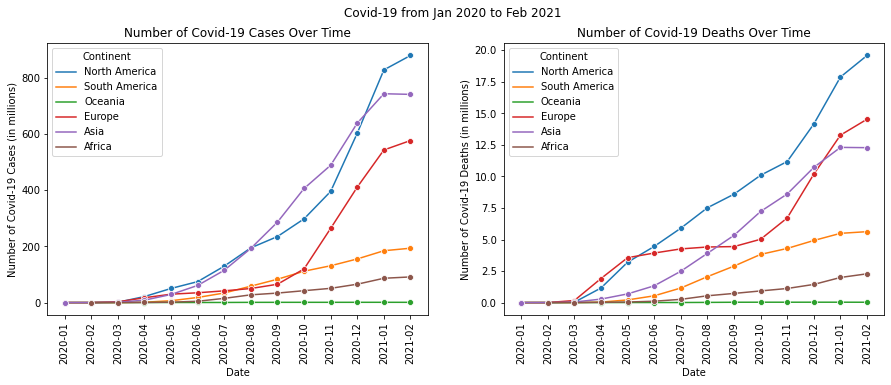

In [13]:
fig, axes = plt.subplots(1,2,sharex=True,figsize=(15,5))
fig.suptitle('Covid-19 from Jan 2020 to Feb 2021')

sns.lineplot(x=df1["Date_ym"].astype(str),y=df1["num_million_cases"],hue=df1["Continent"],marker="o",ax=axes[0])
axes[0].set_title('Number of Covid-19 Cases Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Covid-19 Cases (in millions)')
axes[0].tick_params(axis='x',labelrotation = 90)

sns.lineplot(x=df1["Date_ym"].astype(str),y=df1["num_million_deaths"],hue=df1["Continent"],marker="o",ax=axes[1])
axes[1].set_title('Number of Covid-19 Deaths Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Covid-19 Deaths (in millions)')
axes[1].tick_params(axis='x',labelrotation = 90)

Visualisation 1 shows that most of the continents are experiencing an increase in both the number of Covid-19 cases and deaths since January 2020.

## Visualisation 2

This visualisation shows the total number of Covid-19 cases recorded in each country from 1 January 2020 to 28 February 2021.

In [14]:
df2 = df.groupby(['Entity','Latitude','Longitude']).agg(num_cases=('Cases','sum')).reset_index()
df2['num_million_cases'] = df2['num_cases']/1000000
df2.sort_values('num_million_cases', ascending=False)

,Entity,Latitude,Longitude,num_cases,num_million_cases
99,United States,37.09,-95.71,3.228497e+09,3228.496695
36,India,20.59,78.96,1.717154e+09,1717.153550
78,Russia,61.52,105.32,5.152391e+08,515.239094
30,France,46.23,2.21,3.993233e+08,399.323274
98,United Kingdom,55.38,-3.44,3.890519e+08,389.051873
...,...,...,...,...,...
65,New Zealand,-40.90,174.89,6.065170e+05,0.606517
101,Vietnam,14.06,108.28,3.292080e+05,0.329208
59,Mongolia,46.86,103.85,2.065820e+05,0.206582
10,Bhutan,27.51,90.43,1.029170e+05,0.102917


In [15]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


[Text(0.5, 1.0, 'Total Number of Covid-19 Cases')]

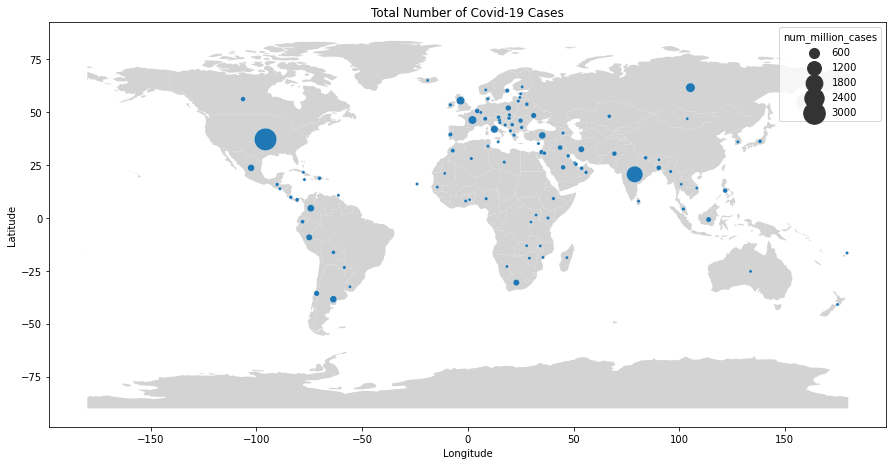

In [16]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
countries.plot(color='lightgrey',ax=ax)
sns.scatterplot(data=df2,x='Longitude',y='Latitude',size='num_million_cases',sizes=(10,500)).set(title="Total Number of Covid-19 Cases")

Visualisation 2 facilitates the comparison of the total number of Covid-19 cases among countries. The United States, a North American country and India, an Asian country have significantly more Covid-19 cases than the other countries.

## Visualisation 3

This visualisation shows how median age and the number of hospital beds per 1000 people are correlated with the number of Covid-19 deaths.

In [22]:
test = df.groupby('Entity').agg(change_age=('Median age','nunique'),change_beds=('Hospital beds per 1000 people','nunique'))
test[(test.change_age!=1)|(test.change_beds!=1)]
# check that the median age and the number of hospital beds per 1000 people are the same across all records for each country

,change_age,change_beds
Entity,,


In [26]:
df3 = df.groupby(['Entity','Continent','Median age','Hospital beds per 1000 people']).agg(num_deaths=('Deaths','sum')).reset_index()
df3['num_million_deaths'] = df3['num_deaths']/1000000
df3.head()

,Entity,Continent,Median age,Hospital beds per 1000 people,num_deaths,num_million_deaths
0,Albania,Europe,38,2.89,171892.0,0.171892
1,Algeria,Africa,29,1.90,547843.0,0.547843
2,Argentina,South America,31,5.00,6622663.0,6.622663
3,Armenia,Europe,35,4.20,428678.0,0.428678
4,Australia,Oceania,37,3.84,186575.0,0.186575


Text(0, 0.5, 'Number of Covid-19 Deaths (in millions)')

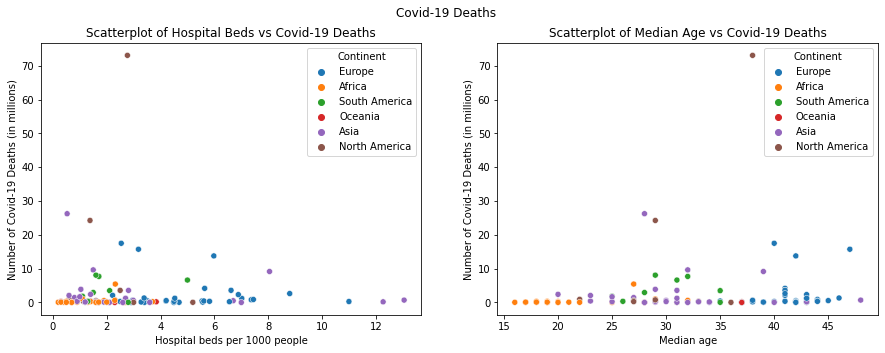

In [27]:
fig, axes = plt.subplots(1,2,sharex=False,figsize=(15,5))
fig.suptitle('Covid-19 Deaths')

sns.scatterplot(x=df3['Hospital beds per 1000 people'],y=df3['num_million_deaths'],hue=df3['Continent'],ax=axes[0])
axes[0].set_title('Scatterplot of Hospital Beds vs Covid-19 Deaths')
axes[0].set_xlabel('Hospital beds per 1000 people')
axes[0].set_ylabel('Number of Covid-19 Deaths (in millions)')

sns.scatterplot(x=df3['Median age'],y=df3['num_million_deaths'],hue=df3['Continent'],ax=axes[1])
axes[1].set_title('Scatterplot of Median Age vs Covid-19 Deaths')
axes[1].set_xlabel('Median age')
axes[1].set_ylabel('Number of Covid-19 Deaths (in millions)')

Fewer number of hospital beds appears to be correlated with a higher number of Covid-19 deaths. Besides, there appears to be a weak correlation between the country's median age and the number of Covid-19 deaths.

In [20]:
df.groupby('Entity').agg(num_unique_records=('Date','nunique'), min_date=('Date',np.min), max_date=('Date', np.max))
# only some countries have records for all dates from 1 Jan 2020 to 28 Feb 2022

,num_unique_records,min_date,max_date
Entity,,,
Albania,370,2020-02-25,2021-02-28
Algeria,370,2020-02-25,2021-02-28
Argentina,404,2020-01-01,2021-02-28
Armenia,365,2020-03-01,2021-02-28
Australia,400,2020-01-26,2021-02-28
...,...,...,...
United States,404,2020-01-22,2021-02-28
Uruguay,353,2020-03-13,2021-02-28
Vietnam,403,2020-01-23,2021-02-28
